In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import dill as pickle

import torch
import pyro
import pyro.distributions as dist
from pyro.infer.autoguide import AutoNormal, AutoMultivariateNormal, AutoDelta
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from chirho.indexed.handlers import IndexPlatesMessenger
from chirho.counterfactual.handlers import MultiWorldCounterfactual
from chirho.indexed.ops import IndexSet, gather, indices_of
from chirho.interventional.handlers import do
from chirho.observational.handlers import condition


from cities.utils.data_grabber import (DataGrabber, list_available_features, list_tensed_features)
from cities.utils.cleaning_utils import check_if_tensed 
from cities.modeling.model_interactions import cities_model_interactions
from cities.modeling.modeling_utils import plot_predictive, prep_data_for_interaction_inference

from pyro.infer import Predictive



ImportError: cannot import name 'prep_data_for_interaction_inference' from 'cities.modeling.modeling_utils' (/home/rafal/s78projects/cities/cities/modeling/modeling_utils.py)

In [ ]:
prep_data_for_interaction_inference(outcome_dataset, intervention_dataset, intervention_variable, forward_shift):
    

In [3]:
dg = DataGrabber()

#original development settings
outcome_dataset = 'unemployment_rate' #outcome variable = its dataset name
intervention_dataset = 'spending_commerce'
intervention_variable = 'total_obligated_amount' #intervention variable
forward_shift = 2 # how many discrete steps forward we'll be trying to predict

#second tested setting
# outcome_dataset = 'gdp' #outcome variable = its dataset name
# intervention_dataset = 'spending_commerce'
# intervention_variable = 'total_obligated_amount' #intervention variable
# forward_shift = 2 # how many discrete steps forward we'll be trying to predict


#third tested setting
# outcome_dataset = 'gdp' #outcome variable = its dataset name
# intervention_dataset = 'spending_transportation'
# intervention_variable = 'total_obligated_amount' #intervention variable
# forward_shift = 1 # how many discrete steps forward we'll be trying to predict


tensed_covariates_datasets = [var for var in list_tensed_features() if var not in [outcome_dataset, intervention_dataset]]
fixed_covariates_datasets = [var for var in list_available_features() if var not in tensed_covariates_datasets + [outcome_dataset, intervention_dataset]]

# at least for now we will use only fixed covariates
# as other time series have different time spans, year missingness etc.

# morever you don't want to use time series from after the first recorded intervention
# so what we could consider doing is adding info from the time series
# for years preceding the first recorded intervention year
# but that's for later

dg.get_features_std_long(list_available_features()) 
dg.get_features_std_wide(list_available_features()) 

# we need to focus on years for which we have data on both the intervention and outcome
# for now, find the boundary years

year_min = max(dg.std_long[intervention_dataset]['Year'].min(), dg.std_long[outcome_dataset]['Year'].min())
year_max = min(dg.std_long[intervention_dataset]['Year'].max(), dg.std_long[outcome_dataset]['Year'].max())

outcome_df = dg.std_long[outcome_dataset].sort_values(by=['GeoFIPS', 'Year'])


# now we adding forward shift to the outcome
# cleaning up and puting intervention/outcome in one df
# and fixed covariates in another

outcome_df[f'{outcome_dataset}_shifted_by_{forward_shift}'] = None

geo_subsets = []
for geo_fips in outcome_df['GeoFIPS'].unique():
    geo_subset = outcome_df[outcome_df['GeoFIPS'] == geo_fips].copy()
    # Shift the 'Value' column `forward_shift` in a new column
    geo_subset[f'{outcome_dataset}_shifted_by_{forward_shift}'] = geo_subset['Value'].shift(-forward_shift)
    geo_subsets.append(geo_subset)
    
outcome_df = pd.concat(geo_subsets).reset_index(drop=True)


outcome = outcome_df[(outcome_df['Year'] >= year_min) & (outcome_df['Year'] <= year_max + forward_shift)]
intervention = dg.std_long[intervention_dataset][(dg.std_long[intervention_dataset]['Year'] >= year_min) & (dg.std_long[intervention_dataset]['Year'] <= year_max)]    
f_covariates = {dataset: dg.std_wide[dataset] for dataset in fixed_covariates_datasets}
f_covariates_joint = f_covariates[fixed_covariates_datasets[0]]
for dataset in f_covariates.keys():
    if dataset != fixed_covariates_datasets[0]:
        if 'GeoName' in f_covariates[dataset].columns:
            f_covariates[dataset] = f_covariates[dataset].drop(columns=['GeoName'])
        f_covariates_joint = f_covariates_joint.merge(f_covariates[dataset], on=['GeoFIPS'])


i_o_data = pd.merge(outcome, intervention, on=['GeoFIPS', 'Year'])

if 'GeoName_x' in i_o_data.columns:
    i_o_data.rename(columns={'GeoName_x': "GeoName"}, inplace=True)    
    columns_to_drop = i_o_data.filter(regex=r'^GeoName_[a-zA-Z]$')
    i_o_data.drop(columns=columns_to_drop.columns, inplace=True)

i_o_data.rename(columns={'Value': outcome_dataset}, inplace=True)

i_o_data['state'] = [code // 1000 for code in i_o_data['GeoFIPS']]

N_s = len(i_o_data['state'].unique())  #number of states
i_o_data.dropna(inplace=True)


i_o_data['unit_index']= pd.factorize(i_o_data['GeoFIPS'].values)[0]
i_o_data['state_index']= pd.factorize(i_o_data['state'].values)[0]
i_o_data['time_index']= pd.factorize(i_o_data['Year'].values)[0]


assert i_o_data['GeoFIPS'].isin(f_covariates_joint['GeoFIPS']).all()

f_covariates_joint.drop(columns=['GeoName'], inplace=True)
data = i_o_data.merge(f_covariates_joint, on='GeoFIPS', how='left')

assert not data.isna().any().any()

time_index_idx = data.columns.get_loc('time_index')
covariates_df = data.iloc[:, time_index_idx + 1:].copy()
covariates_df_sparse = covariates_df.copy()
covariates_df_sparse['unit_index'] = data['unit_index']
covariates_df_sparse['state_index'] = data['state_index']
covariates_df_sparse.drop_duplicates(inplace=True)
assert set(covariates_df_sparse['unit_index']) == set(data['unit_index'])


In [4]:
# get tensors for modeling

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

y = data[f'{outcome_dataset}_shifted_by_{forward_shift}']
y = torch.tensor(y, dtype=torch.float32, device = device) 

unit_index = torch.tensor(data['unit_index'], dtype=torch.int, device = device)
unit_index_sparse = torch.tensor(covariates_df_sparse['unit_index'], dtype=torch.int)

state_index = torch.tensor(data['state_index'], dtype=torch.int, device = device)
state_index_sparse = torch.tensor(covariates_df_sparse['state_index'], dtype=torch.int)

time_index = torch.tensor(data['time_index'], dtype=torch.int, device = device)
intervention = torch.tensor(data[intervention_variable], dtype=torch.float32, device = device)

covariates = torch.tensor(covariates_df.values, dtype = torch.float32, device = device)

covariates_df_sparse.drop(columns=['unit_index','state_index'], inplace=True)
covariates_sparse = torch.tensor(covariates_df_sparse.values, dtype = torch.float32, device = device)

N_cov = covariates.shape[1] #number of covariates
N_u = covariates_sparse.shape[0] #number of units (counties)
N_obs = len(y) #number of observations
N_t = len(time_index.unique()) #number of time points
N_s = len(state_index.unique()) #number of states

assert len(intervention) == len(y)
assert len(unit_index) == len(y)
assert len(state_index) == len(unit_index)
assert len(time_index) == len(unit_index)
assert covariates.shape[1] == covariates_sparse.shape[1]
assert len(unit_index_sparse) == N_u


Y_bias torch.Size([])
T_bias torch.Size([])
weight_TY torch.Size([])
sigma_T torch.Size([])
sigma_Y torch.Size([])
X_bias torch.Size([30, 1, 1, 1])
sigma_X torch.Size([30, 1, 1, 1])
weight_XT torch.Size([30, 1, 1, 1])
weight_XY torch.Size([30, 1, 1, 1])
weight_UsT torch.Size([51, 1, 1])
weight_UsY torch.Size([51, 1, 1])
weight_UsX torch.Size([30, 51, 1, 1])
weight_UtT torch.Size([11, 1, 1, 1, 1])
weight_UtY torch.Size([11, 1, 1, 1, 1])
X torch.Size([2998, 30])
T torch.Size([9124])
Y torch.Size([9124])
traced_X torch.Size([2998, 30])
covariates torch.Size([2998, 30])


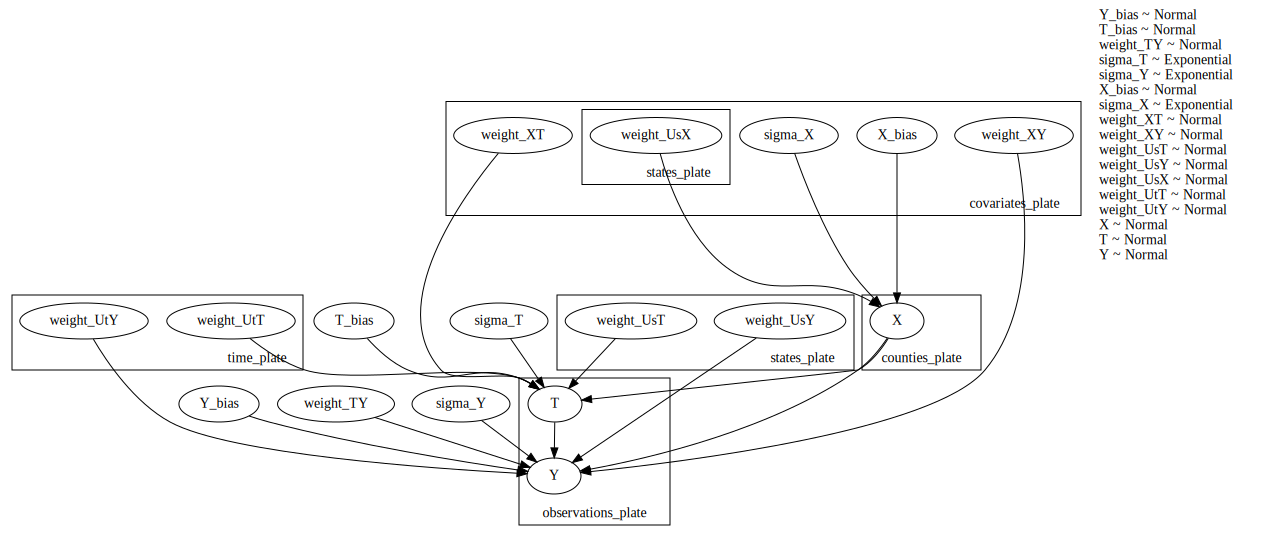

In [5]:
leeway = .2


def cities_model_F(N_t, N_s, state_index, time_index):
    
    Y_bias = pyro.sample("Y_bias", dist.Normal(0, leeway))
    T_bias = pyro.sample("T_bias", dist.Normal(0, leeway))

    weight_TY = pyro.sample("weight_TY", dist.Normal(0, leeway))
    
    
    sigma_T = pyro.sample("sigma_T", dist.Exponential(1))
    sigma_Y = pyro.sample("sigma_Y", dist.Exponential(1))

    observations_plate = pyro.plate("observations_plate", N_obs, dim = -1)
    counties_plate = pyro.plate("counties_plate", N_u, dim = -2)
    states_plate = pyro.plate("states_plate", N_s, dim=-3)
    covariates_plate = pyro.plate("covariates_plate", N_cov, dim=-4)
    time_plate = pyro.plate("time_plate", N_t, dim=-5)


    with covariates_plate:
        X_bias = pyro.sample("X_bias", dist.Normal(0, leeway)).squeeze()
        sigma_X = pyro.sample("sigma_X", dist.Exponential(1)).squeeze()
        weight_XT = pyro.sample("weight_XT", dist.Normal(0, leeway)).squeeze()
        weight_XY = pyro.sample("weight_XY", dist.Normal(0, leeway)).squeeze()



    with states_plate:
        weight_UsT = pyro.sample("weight_UsT", dist.Normal(0, leeway)).squeeze()      
        weight_UsY = pyro.sample("weight_UsY", dist.Normal(0, leeway)).squeeze()        

        with covariates_plate:
            weight_UsX = pyro.sample("weight_UsX", dist.Normal(0, leeway)).squeeze()

    

    with time_plate:
        weight_UtT = pyro.sample("weight_UtT", dist.Normal(0, leeway)).squeeze()
        weight_UtY = pyro.sample("weight_UtY", dist.Normal(0, leeway)).squeeze()

   
    with counties_plate:
        # squeezing added to avoid shape errors when predictive sampling
        # as values get dimensions of size 1 (on both sides of non-trival dims)
        #UsX_weighted = torch.einsum("ij...,j...->ij", weight_UsX.squeeze(), Us.squeeze())
        
        UsX_weight_selected = weight_UsX.squeeze().T.squeeze()[state_index_sparse]     
        X_means = torch.einsum("c,uc->uc" ,X_bias, UsX_weight_selected)
        X = pyro.sample("X", dist.Normal(X_means, sigma_X)).squeeze()


    XT_weighted = torch.einsum("uc, c -> u",X, weight_XT)
    XY_weighted = torch.einsum("uc, c -> u", X, weight_XY) 
    
    with observations_plate:

        T_mean = (T_bias + weight_UtT[time_index] 
                  + weight_UsT[state_index]
                  + XT_weighted[unit_index]
                  )
        
        T =  pyro.sample("T", dist.Normal(T_mean, sigma_T))

    
        Y_mean = (Y_bias + weight_UtY[time_index] 
                + weight_UsY[state_index] 
                + weight_TY * T 
                + XY_weighted[unit_index]
                 )   

        Y = pyro.sample("Y", dist.Normal(Y_mean, sigma_Y))


    return


with pyro.poutine.trace() as tr:
    cities_model_F(N_t, N_s, state_index, time_index)


for key in tr.trace.nodes.keys():
    if not key.endswith("_plate"):
        print(key, tr.trace.nodes[key]["value"].shape)

print("traced_X", tr.trace.nodes["X"]["value"].shape)
print("covariates", covariates_sparse.shape)

assert tr.trace.nodes["T"]["value"].shape == intervention.shape, "T shape issues"
assert tr.trace.nodes["Y"]["value"].shape == y.shape, "Y shape issues"


pyro.render_model(cities_model_F, 
                  model_args=(N_t, N_s, state_index, time_index), render_distributions=True)

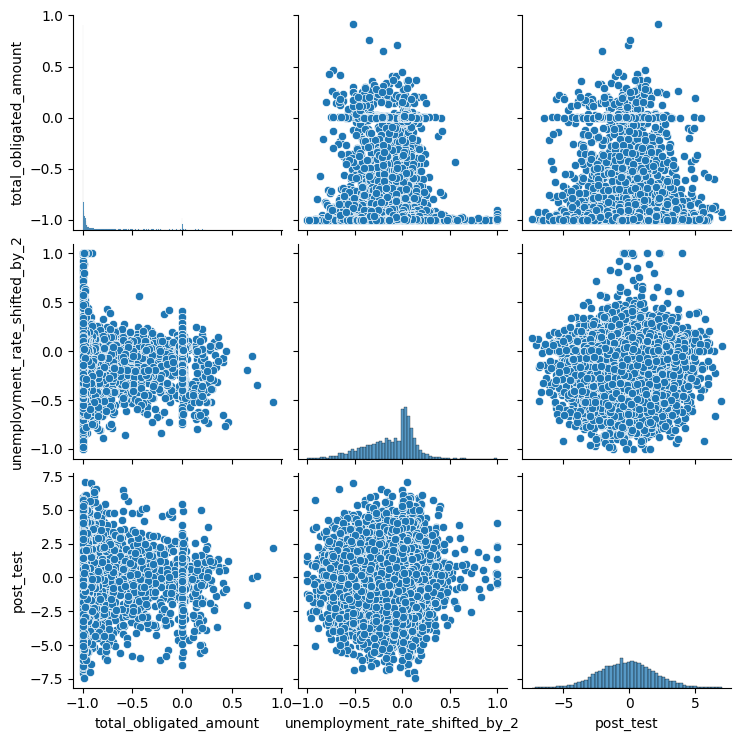

In [6]:
#TODO: double check after data transformations 

prior_Y = tr.trace.nodes['Y']['value']
predictive_copy = data.copy()
predictive_copy['post_test'] = prior_Y.reshape(-1, 1).detach().numpy() 
sns.pairplot(predictive_copy[[intervention_variable, f"{outcome_dataset}_shifted_by_{forward_shift}", 'post_test']]) 

[iteration 0001] loss: 12.7156
[iteration 0101] loss: 4.0398
[iteration 0201] loss: 1.9503
[iteration 0301] loss: 2.0563
[iteration 0401] loss: 1.6484
[iteration 0501] loss: 1.8397
[iteration 0601] loss: 1.5366
[iteration 0701] loss: 1.4895
[iteration 0801] loss: 1.3719
[iteration 0901] loss: 1.4762


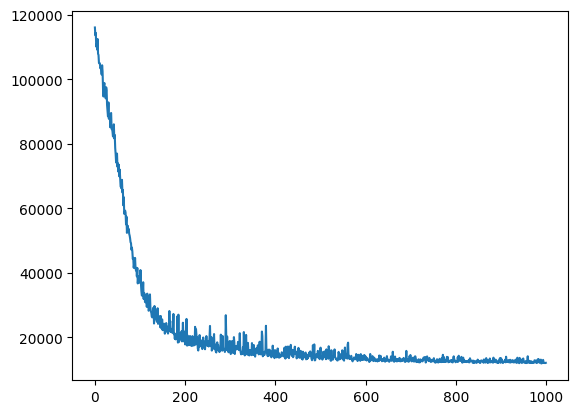

In [7]:
cities_model_F_conditioned = pyro.condition(cities_model_F, data = {"T": intervention, "Y": y, "X": covariates_sparse})

pyro.clear_param_store()
guide_F =  AutoNormal(cities_model_F_conditioned)

svi = SVI(
    model=cities_model_F_conditioned,
    guide=guide_F,
    optim=Adam({"lr": 0.01}),
    loss=Trace_ELBO()  
)

losses = []
num_iterations = 1000
for step in range(num_iterations):
    loss = svi.step(N_t, N_s, state_index, time_index)
    losses.append(loss)
    if step % 100 == 0:
        print('[iteration %04d] loss: %.4f' % (step + 1, loss / N_obs))

plt.plot(range(num_iterations),losses, label="Loss")
plt.show()

In [8]:
predictive_F = pyro.infer.Predictive(cities_model_F, guide=guide_F, num_samples=1000, parallel=False)
samples_F = predictive_F(N_t, N_s, state_index, time_index)

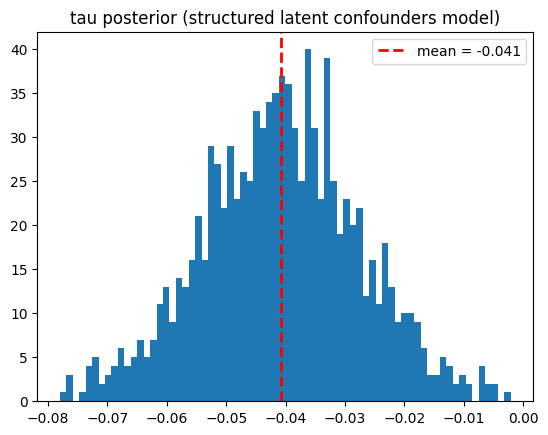

In [9]:
# estimate with covariates and latent confounders impacting covariates, intervention, and outcome
tau_samples = samples_F['weight_TY'].squeeze().detach().numpy()

plt.hist(tau_samples,bins = 70)
plt.axvline(x=tau_samples.mean(), color='red', linestyle='dashed', linewidth=2, label=f'mean = {tau_samples.mean():.3f}')
plt.title("tau posterior (structured latent confounders model)")
plt.legend()
plt.show()

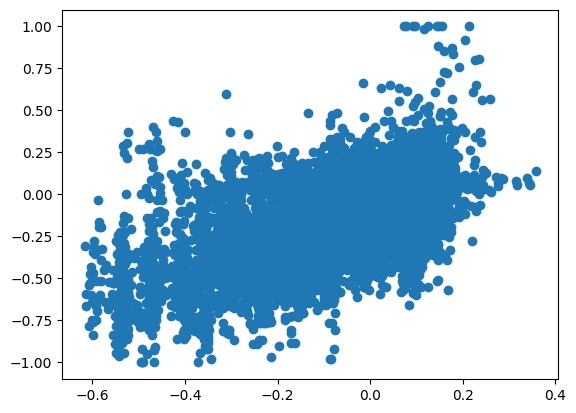

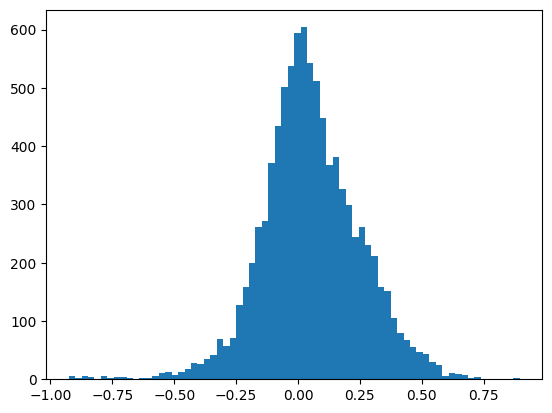

In [10]:
predictions = samples_F['Y'].squeeze().T
mean_predictions = torch.mean(predictions, dim = 1)


plt.scatter(x = mean_predictions,y =  y)
plt.show()

plt.hist(mean_predictions - y, bins=70)
plt.show()

In [11]:
observed_mean = torch.mean(y)
tss = torch.sum((y - observed_mean) ** 2)
print("tss", tss)
rss = torch.sum((y - mean_predictions) ** 2)
print("rss", rss)
r_squared = 1 - (rss / tss)
print("r_squared", r_squared)

tss tensor(594.6318)
rss tensor(386.0097)
r_squared tensor(0.3508)


In [13]:


with MultiWorldCounterfactual() as mwc_D:
    with do(actions=dict(intervention=(-0.9, .9))):
        samples_F = predictive_F(N_t= N_t, N_s = N_s, state_index = state_index,
                            time_index = time_index)
        